In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Portuguese.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Polish.txt', 'data/names/German.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/English.txt']


In [2]:
import torch

def oneHotEncode(letter, nsize = n_letters):
    v = torch.zeros(1, nsize)
    v[0][all_letters.find(letter)] = 1
    return v

def wordToTensor(word, nsize = n_letters):
    tensor = torch.zeros(len(word), 1, n_letters)
    for it, c in enumerate(word):
        tensor[it][0] = oneHotEncode(c)
    return tensor

In [3]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size, bias = True)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.softmax(self.i2o(combined))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [4]:
def argMax(output):
    top_i = output[0].topk(2, sorted = True) 
    ##value/index ith elemtn
    category_i = top_i[1][0].item()
    return all_categories[category_i], category_i


In [5]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = wordToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Marek
category = Czech / line = Ruzicka
category = Czech / line = Ajdrna
category = German / line = Martell
category = Spanish / line = Quintana
category = Korean / line = Rheem
category = Scottish / line = Mclean
category = Portuguese / line = De santigo
category = Czech / line = Pavlicka
category = Scottish / line = Mcintyre


In [6]:
criterion = nn.NLLLoss()

In [7]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [8]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = argMax(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.4558 Simoes / Greek ✗ (Portuguese)
10000 10% (0m 20s) 1.7702 Torres / Portuguese ✓
15000 15% (0m 30s) 1.3352 Vuu / Korean ✗ (Vietnamese)
20000 20% (0m 40s) 1.3081 Sabbag / Arabic ✓
25000 25% (0m 50s) 1.0810 Etxeberria / Spanish ✓
30000 30% (1m 1s) 1.5891 Silveira / Czech ✗ (Portuguese)
35000 35% (1m 11s) 0.9915 Attia / Arabic ✓
40000 40% (1m 21s) 2.7343 Reyer / German ✗ (French)
45000 45% (1m 31s) 0.8090 Mo / Korean ✓
50000 50% (1m 41s) 0.0832 Nassar / Arabic ✓
55000 55% (1m 51s) 2.9337 Atiyeh / Czech ✗ (Arabic)
60000 60% (2m 1s) 2.5307 Cuellar / Irish ✗ (Spanish)
65000 65% (2m 11s) 1.0321 Snijder / Dutch ✓
70000 70% (2m 21s) 3.6362 Aonghuis / Chinese ✗ (Irish)
75000 75% (2m 31s) 1.4329 Castellano / Italian ✗ (Spanish)
80000 80% (2m 41s) 0.9523 O'Byrne / Irish ✓
85000 85% (2m 52s) 0.7712 Terajima / Japanese ✓
90000 90% (3m 2s) 0.2238 Paulissen / Dutch ✓
95000 95% (3m 12s) 1.3026 Moy / Korean ✗ (Chinese)
100000 100% (3m 22s) 0.9312 Gomes / Portuguese ✓


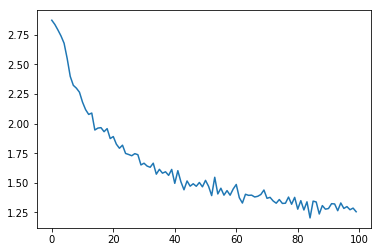

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

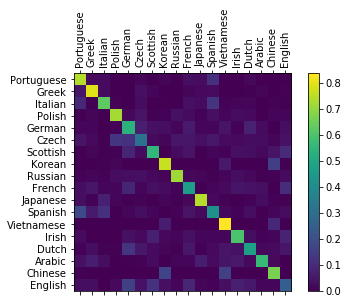

In [10]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = argMax(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [11]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(wordToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.46) Russian
(-1.36) Czech
(-3.14) English

> Jackson
(-1.09) Russian
(-1.30) English
(-1.78) Scottish

> Satoshi
(-1.18) Italian
(-1.46) Japanese
(-1.98) Polish
